In [1]:
import tensorflow as tf
from IPython.display import Image, display

import matplotlib.pyplot as plt
import tensorflow_hub as hub

import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
!wget https://storage.googleapis.com/ibeans/train.zip
!wget https://storage.googleapis.com/ibeans/validation.zip
!wget https://storage.googleapis.com/ibeans/test.zip


--2023-11-14 13:07:59--  https://storage.googleapis.com/ibeans/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.167.207, 142.251.16.207, 172.253.62.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.167.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143812152 (137M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 137.15M  80.8MB/s    in 1.7s    

2023-11-14 13:08:01 (80.8 MB/s) - ‘train.zip’ saved [143812152/143812152]

--2023-11-14 13:08:01--  https://storage.googleapis.com/ibeans/validation.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.167.207, 142.251.16.207, 172.253.62.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.167.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18504213 (18M) [application/zip]
Saving to: ‘validation.zip’

validation.zip      100%[===============

In [4]:
!mkdir beans

In [5]:
!unzip train.zip -d beans/
!unzip test.zip -d beans/
!unzip validation.zip -d beans/

Archive:  train.zip
   creating: beans/train/
   creating: beans/train/healthy/
   creating: beans/train/angular_leaf_spot/
   creating: beans/train/bean_rust/
  inflating: beans/train/healthy/healthy_train.265.jpg  
  inflating: beans/train/healthy/healthy_train.271.jpg  
  inflating: beans/train/healthy/healthy_train.259.jpg  
  inflating: beans/train/healthy/healthy_train.99.jpg  
  inflating: beans/train/healthy/healthy_train.311.jpg  
  inflating: beans/train/healthy/healthy_train.66.jpg  
  inflating: beans/train/healthy/healthy_train.72.jpg  
  inflating: beans/train/healthy/healthy_train.305.jpg  
  inflating: beans/train/healthy/healthy_train.339.jpg  
  inflating: beans/train/healthy/healthy_train.113.jpg  
  inflating: beans/train/healthy/healthy_train.107.jpg  
  inflating: beans/train/healthy/healthy_train.106.jpg  
  inflating: beans/train/healthy/healthy_train.112.jpg  
  inflating: beans/train/healthy/healthy_train.338.jpg  
  inflating: beans/train/healthy/healthy_trai

In [6]:
!ls beans

test  train  validation


In [7]:
!ls beans/train

angular_leaf_spot  bean_rust  healthy


In [8]:
!ls beans/test

angular_leaf_spot  bean_rust  healthy


In [9]:
!ls beans/validation

angular_leaf_spot  bean_rust  healthy


In [10]:
!find beans -type f | wc -l

1296


In [11]:
!find beans/test -type f | wc -l

128


In [12]:
!find beans/validation -type f | wc -l

133


**Healthy Leaf**

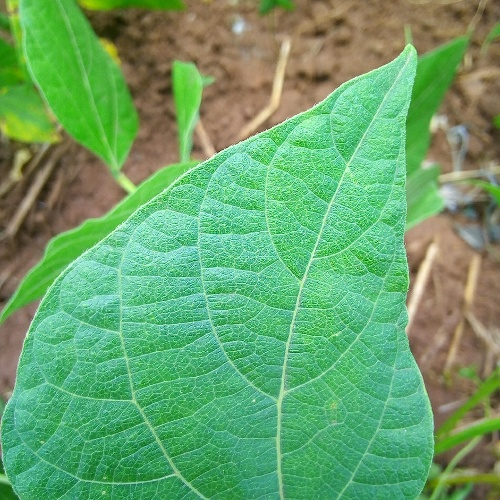

In [13]:
display(Image('/content/beans/train/healthy/healthy_train.0.jpg'))

**Unhealthy Leaf**

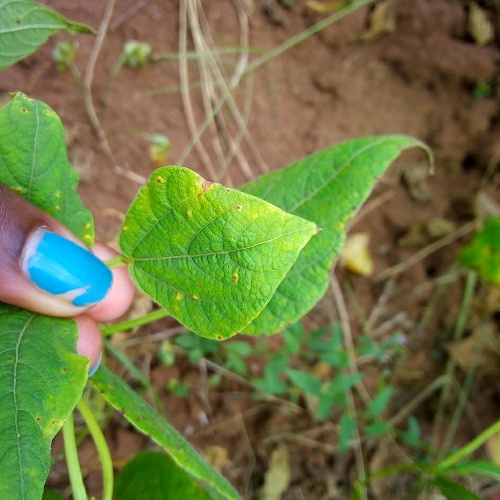

In [14]:
display(Image('/content/beans/train/bean_rust/bean_rust_train.0.jpg'))

**Unhealthy Leaf**

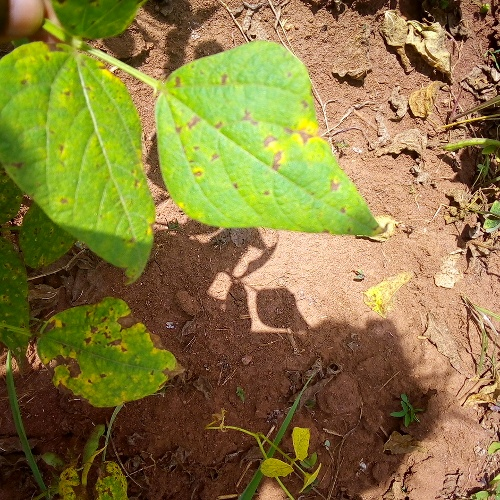

In [15]:
display(Image('/content/beans/train/angular_leaf_spot/angular_leaf_spot_train.0.jpg'))

In [16]:
batch_size = 128
img_height = 224
img_width = 224

In [17]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'beans/train',
    seed = 111,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 1034 files belonging to 3 classes.


In [18]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'beans/test',
    seed = 111,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 128 files belonging to 3 classes.


In [19]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'beans/validation',
    seed = 111,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 133 files belonging to 3 classes.


In [20]:
for image_batch, labels_batch in train_ds :
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 224, 224, 3)
(128,)


In [21]:
classes = train_ds.class_names
classes

['angular_leaf_spot', 'bean_rust', 'healthy']

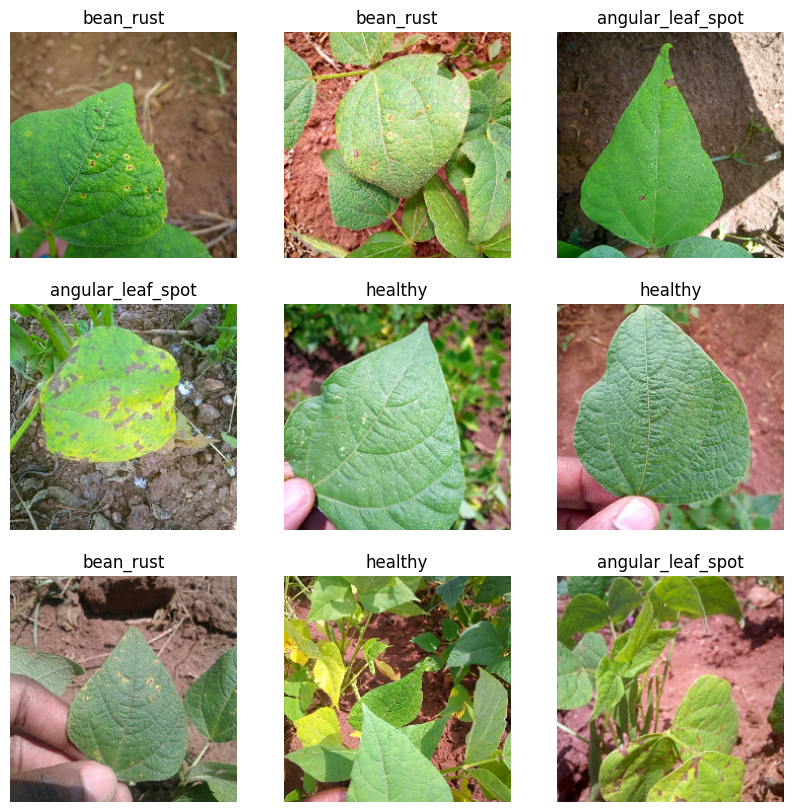

In [22]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1) :
  for i in range(9) :
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [25]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape = (img_height,img_width,3))

In [26]:
feature_extractor_layer.trainable = False

In [27]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [28]:
tf.random.set_seed(111)

In [29]:
model = tf.keras.Sequential([
    normalization_layer,
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [31]:
history = model.fit(train_ds, epochs=20,validation_data=val_ds)

Epoch 1/20
9/9 [==============================] - 55s 5s/step - loss: 1.1005 - accuracy: 0.4816 - val_loss: 0.7206 - val_accuracy: 0.7519
Epoch 2/20
9/9 [==============================] - 41s 5s/step - loss: 0.7345 - accuracy: 0.6983 - val_loss: 0.5660 - val_accuracy: 0.7744
Epoch 3/20
9/9 [==============================] - 44s 5s/step - loss: 0.6032 - accuracy: 0.7437 - val_loss: 0.4870 - val_accuracy: 0.7970
Epoch 4/20
9/9 [==============================] - 40s 4s/step - loss: 0.5133 - accuracy: 0.7805 - val_loss: 0.4408 - val_accuracy: 0.8195
Epoch 5/20
9/9 [==============================] - 40s 4s/step - loss: 0.4866 - accuracy: 0.8075 - val_loss: 0.4088 - val_accuracy: 0.8195
Epoch 6/20
9/9 [==============================] - 44s 5s/step - loss: 0.4247 - accuracy: 0.8259 - val_loss: 0.3796 - val_accuracy: 0.8571
Epoch 7/20
9/9 [==============================] - 41s 5s/step - loss: 0.3879 - accuracy: 0.8385 - val_loss: 0.3619 - val_accuracy: 0.8647
Epoch 8/20
9/9 [==================

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


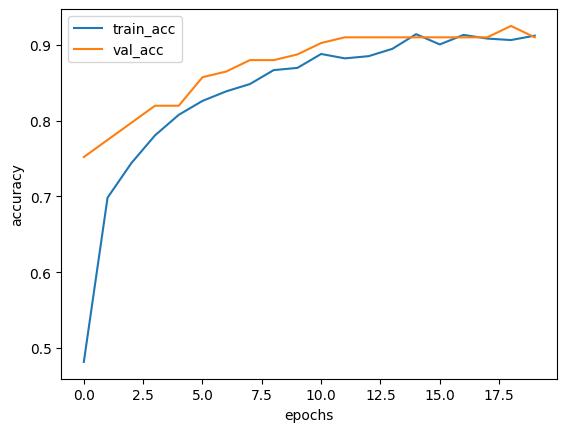

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train_acc','val_acc'],loc='best')
plt.show()

In [34]:
result = model.evaluate(test_ds)

1/1 [==============================] - 6s 6s/step - loss: 0.2522 - accuracy: 0.9141


1/1 [==============================] - 0s 61ms/step


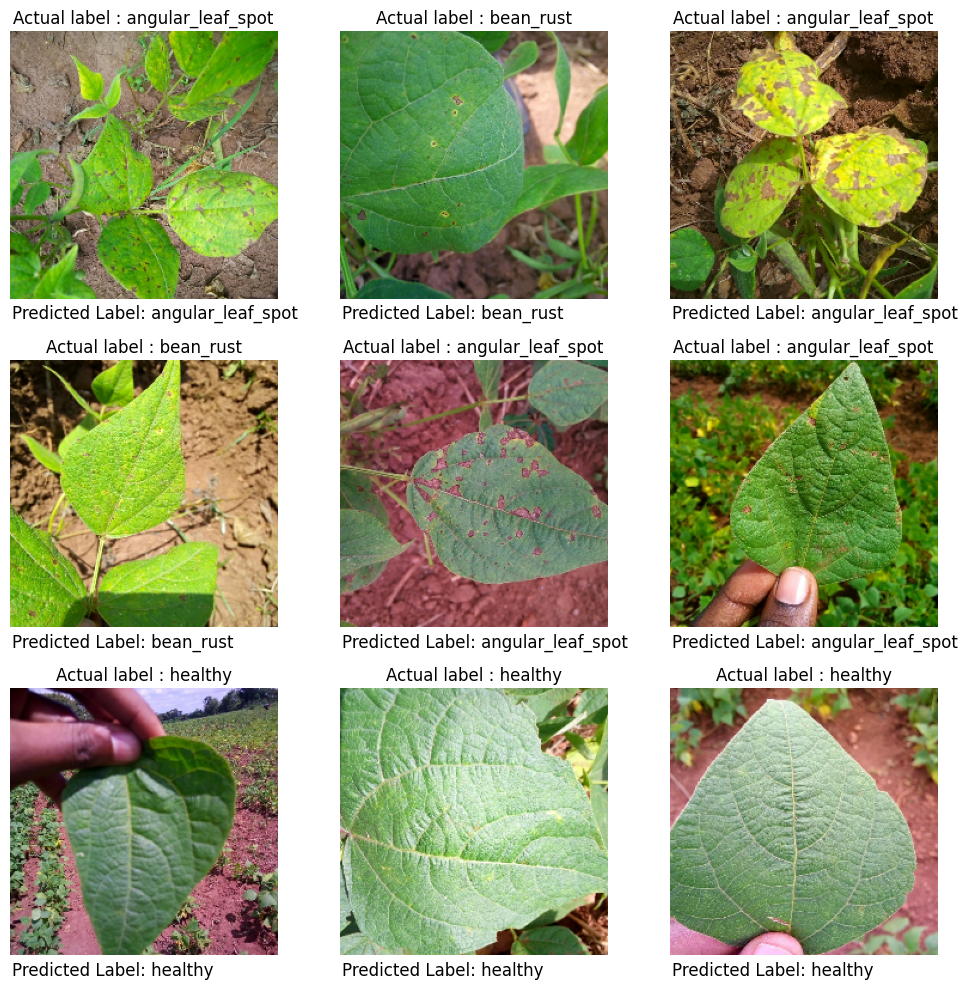

In [37]:
plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1) :
  for i in range(9) :
    ax = plt.subplot(3,3, i + 1)

    plt.tight_layout()

    img = tf.keras.preprocessing.image.img_to_array(images[i])
    img = np.expand_dims(img, axis = 0)

    pred = model.predict(img)

    plt.imshow(images[i].numpy().astype("uint8"))

    plt.title("Actual label : %s"% classes[labels[i]])
    plt.text(1,240, "Predicted Label: %s" % classes[np.argmax(pred)], fontsize=12)

    plt.axis("off")

In [38]:
model.save('./models', save_format='tf')

In [39]:
!ls models

assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables


In [40]:
!ls -alrt models

total 1880
drwxr-xr-x 1 root root    4096 Nov 14 13:31 ..
drwxr-xr-x 2 root root    4096 Nov 14 13:31 variables
drwxr-xr-x 2 root root    4096 Nov 14 13:31 assets
-rw-r--r-- 1 root root 1894625 Nov 14 13:31 saved_model.pb
-rw-r--r-- 1 root root      56 Nov 14 13:31 fingerprint.pb
-rw-r--r-- 1 root root    7640 Nov 14 13:31 keras_metadata.pb
drwxr-xr-x 4 root root    4096 Nov 14 13:31 .


In [41]:
model_loaded = tf.keras.models.load_model('./models/')

In [42]:
model_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [43]:
from PIL import Image
import numpy as np
from skimage import transform
def process(filename) :
  np_image = Image.open(filename)
  np_image = np.array(np_image).astype('float32')
  np_image = transform.resize(np_image, (224,224,3))
  np_image = np.expand_dims(np_image, axis=0)
  return np_image

In [44]:
pred_label = model_loaded.predict(process('/content/beans/train/healthy/healthy_train.0.jpg'))
print(classes[np.argmax(pred_label)])

1/1 [==============================] - 1s 1s/step
healthy


In [45]:
pred_label

array([[4.3205029e-04, 3.2505628e-02, 9.6706229e-01]], dtype=float32)

In [46]:
!zip -r models.zip models/

  adding: models/ (stored 0%)
  adding: models/fingerprint.pb (stored 0%)
  adding: models/variables/ (stored 0%)
  adding: models/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: models/variables/variables.index (deflated 78%)
  adding: models/assets/ (stored 0%)
  adding: models/saved_model.pb (deflated 91%)
  adding: models/keras_metadata.pb (deflated 82%)


In [47]:
print(tf.__version__)

2.14.0
